# Load pre-requisites from Google Drive

In [ ]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


## Retrieve code files from mounted Google Drive

In [ ]:
!cp -r "./gdrive/My Drive/DLProject/Code_Implementation/Retinex-net" .
# !rm -rf ./Retinex-net
# It takes 12 minutes

In [ ]:
import os
os.chdir("./Retinex-net")
os.getcwd()

'/content/Retinex-net'

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


# Utils

In [ ]:
import numpy as np
from PIL import Image
import cv2
import os
import glob
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

def load_images(file):
    im = Image.open(file)
    return np.array(im, dtype="float32") / 255.0

def save_images(filepath, result_1, result_2 = None):
    result_1 = np.squeeze(result_1)
    result_2 = np.squeeze(result_2)

    if not result_2.any():
        cat_image = result_1
    else:
        cat_image = np.concatenate([result_1, result_2], axis = 1)

    im = Image.fromarray(np.clip(cat_image * 255.0, 0, 255.0).astype('uint8'))
    im.save(filepath, 'png')

def display_images(directory):
  for path in os.listdir(directory):
    full_path = os.path.join(directory, path)
    if os.path.isfile(full_path):
        print(full_path)
        image = mpimg.imread(full_path)
        plt.imshow(image)
        plt.show()

# Model

In [ ]:
from __future__ import print_function

import os
import time
import random

from PIL import Image
import tensorflow.compat.v1 as tf
import numpy as np

# from utils import *

def concat(layers):
    return tf.concat(layers, axis=3)

def DecomNet(input_im, layer_num, channel=64, kernel_size=3):
    input_max = tf.reduce_max(input_im, axis=3, keepdims=True)
    input_im = concat([input_max, input_im])
    with tf.variable_scope('DecomNet', reuse=tf.AUTO_REUSE):
        conv = tf.layers.conv2d(input_im, channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        for idx in range(layer_num):
            conv = tf.layers.conv2d(conv, channel, kernel_size, padding='same', activation=tf.nn.relu, name='activated_layer_%d' % idx)
        conv = tf.layers.conv2d(conv, 4, kernel_size, padding='same', activation=None, name='recon_layer')

    R = tf.sigmoid(conv[:,:,:,0:3])
    L = tf.sigmoid(conv[:,:,:,3:4])

    return R, L

def RelightNet(input_L, input_R, channel=64, kernel_size=3):
    input_im = concat([input_R, input_L])
    with tf.variable_scope('RelightNet', reuse=tf.AUTO_REUSE):
        conv0 = tf.layers.conv2d(input_im, channel, kernel_size, padding='same', activation=None)
        conv1 = tf.layers.conv2d(conv0, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv2, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        
        up1 = tf.image.resize_nearest_neighbor(conv3, (tf.shape(conv2)[1], tf.shape(conv2)[2]))
        deconv1 = tf.layers.conv2d(up1, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv2
        up2 = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(conv1)[1], tf.shape(conv1)[2]))
        deconv2= tf.layers.conv2d(up2, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv1
        up3 = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(conv0)[1], tf.shape(conv0)[2]))
        deconv3 = tf.layers.conv2d(up3, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv0
        
        deconv1_resize = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        deconv2_resize = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        feature_gather = concat([deconv1_resize, deconv2_resize, deconv3])
        feature_fusion = tf.layers.conv2d(feature_gather, channel, 1, padding='same', activation=None)
        output = tf.layers.conv2d(feature_fusion, 1, 3, padding='same', activation=None)
    return output

class lowlight_enhance(object):
    def __init__(self, sess):
        self.sess = sess
        self.DecomNet_layer_num = 5

        # build the model
		# Low light input Image (S_low)
        self.input_low = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low')
		# Normal light input Image (S_normal)
        self.input_high = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high')

		# Decomposition of input image to Reflectance and Illumination Maps
        [R_low, I_low] = DecomNet(self.input_low, layer_num=self.DecomNet_layer_num)
        [R_high, I_high] = DecomNet(self.input_high, layer_num=self.DecomNet_layer_num)
        
        I_delta = RelightNet(I_low, R_low)

        I_low_3 = concat([I_low, I_low, I_low])
        I_high_3 = concat([I_high, I_high, I_high])
        I_delta_3 = concat([I_delta, I_delta, I_delta])

        self.output_R_low = R_low
        self.output_I_low = I_low_3
        self.output_I_delta = I_delta_3
        self.output_S = R_low * I_delta_3

        # loss
        self.recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  self.input_low))
        self.recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - self.input_high))
        self.recon_loss_mutal_low = tf.reduce_mean(tf.abs(R_high * I_low_3 - self.input_low))
        self.recon_loss_mutal_high = tf.reduce_mean(tf.abs(R_low * I_high_3 - self.input_high))
        self.equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))
        self.relight_loss = tf.reduce_mean(tf.abs(R_low * I_delta_3 - self.input_high))

        self.Ismooth_loss_low = self.smooth(I_low, R_low)
        self.Ismooth_loss_high = self.smooth(I_high, R_high)
        self.Ismooth_loss_delta = self.smooth(I_delta, R_low)

        self.loss_Decom = self.recon_loss_low + self.recon_loss_high + 0.001 * self.recon_loss_mutal_low + 0.001 * self.recon_loss_mutal_high + 0.1 * self.Ismooth_loss_low + 0.1 * self.Ismooth_loss_high + 0.01 * self.equal_R_loss
        self.loss_Relight = self.relight_loss + 3 * self.Ismooth_loss_delta

        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        optimizer = tf.train.AdamOptimizer(self.lr, name='AdamOptimizer')

        self.var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
        self.var_Relight = [var for var in tf.trainable_variables() if 'RelightNet' in var.name]

        self.train_op_Decom = optimizer.minimize(self.loss_Decom, var_list = self.var_Decom)
        self.train_op_Relight = optimizer.minimize(self.loss_Relight, var_list = self.var_Relight)

        self.sess.run(tf.global_variables_initializer())

        self.saver_Decom = tf.train.Saver(var_list = self.var_Decom)
        self.saver_Relight = tf.train.Saver(var_list = self.var_Relight)

        print("[*] Initialize model successfully...")

    def gradient(self, input_tensor, direction):
        self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
        self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

        if direction == "x":
            kernel = self.smooth_kernel_x
        elif direction == "y":
            kernel = self.smooth_kernel_y
        return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))

    def ave_gradient(self, input_tensor, direction):
        return tf.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

    def smooth(self, input_I, input_R):
        input_R = tf.image.rgb_to_grayscale(input_R)
        return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

    def evaluate(self, epoch_num, eval_low_data, sample_dir, train_phase):
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch_num))

        for idx in range(len(eval_low_data)):
            input_low_eval = np.expand_dims(eval_low_data[idx], axis=0)

            if train_phase == "Decom":
                result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.input_low: input_low_eval})
            if train_phase == "Relight":
                result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.input_low: input_low_eval})

            save_images(os.path.join(sample_dir, 'eval_%s_%d_%d.png' % (train_phase, idx + 1, epoch_num)), result_1, result_2)

    def train(self, train_low_data, train_high_data, eval_low_data, batch_size, patch_size, epoch, lr, sample_dir, ckpt_dir, eval_every_epoch, train_phase):
        assert len(train_low_data) == len(train_high_data)
        numBatch = len(train_low_data) // int(batch_size)

        # load pretrained model
        if train_phase == "Decom":
            train_op = self.train_op_Decom
            train_loss = self.loss_Decom
            saver = self.saver_Decom
        elif train_phase == "Relight":
            train_op = self.train_op_Relight
            train_loss = self.loss_Relight
            saver = self.saver_Relight

        load_model_status, global_step = self.load(saver, ckpt_dir)
        if load_model_status:
            iter_num = global_step
            start_epoch = global_step // numBatch
            start_step = global_step % numBatch
            print("[*] Model restore success!")
        else:
            iter_num = 0
            start_epoch = 0
            start_step = 0
            print("[*] Not find pretrained model!")

        print("[*] Start training for phase %s, with start epoch %d start iter %d : " % (train_phase, start_epoch, iter_num))

        start_time = time.time()
        image_id = 0

        for epoch in range(start_epoch, epoch):
            for batch_id in range(start_step, numBatch):
                # generate data for a batch
                batch_input_low = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
                batch_input_high = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
                for patch_id in range(batch_size):
                    h, w, _ = train_low_data[image_id].shape
                    x = random.randint(0, h - patch_size)
                    y = random.randint(0, w - patch_size)
            
                    rand_mode = random.randint(0, 7)
                    batch_input_low[patch_id, :, :, :] = data_augmentation(train_low_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
                    batch_input_high[patch_id, :, :, :] = data_augmentation(train_high_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
                    
                    image_id = (image_id + 1) % len(train_low_data)
                    if image_id == 0:
                        tmp = list(zip(train_low_data, train_high_data))
                        random.shuffle(list(tmp))
                        train_low_data, train_high_data  = zip(*tmp)

                # train
                _, loss = self.sess.run([train_op, train_loss], feed_dict={self.input_low: batch_input_low, \
                                                                           self.input_high: batch_input_high, \
                                                                           self.lr: lr[epoch]})

                print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
                      % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
                iter_num += 1

            # evalutate the model and save a checkpoint file for it
            if (epoch + 1) % eval_every_epoch == 0:
                self.evaluate(epoch + 1, eval_low_data, sample_dir=sample_dir, train_phase=train_phase)
                self.save(saver, iter_num, ckpt_dir, "RetinexNet-%s" % train_phase)

        print("[*] Finish training for phase %s." % train_phase)

    def save(self, saver, iter_num, ckpt_dir, model_name):
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        print("[*] Saving model %s" % model_name)
        saver.save(self.sess, \
                   os.path.join(ckpt_dir, model_name), \
                   global_step=iter_num)

    def load(self, saver, ckpt_dir):
        ckpt = tf.train.get_checkpoint_state(ckpt_dir)
        if ckpt and ckpt.model_checkpoint_path:
            full_path = tf.train.latest_checkpoint(ckpt_dir)
            try:
                global_step = int(full_path.split('/')[-1].split('-')[-1])
            except ValueError:
                global_step = None
            saver.restore(self.sess, full_path)
            return True, global_step
        else:
            print("[*] Failed to load model from %s" % ckpt_dir)
            return False, 0

    def test(self, test_low_data, test_high_data, test_low_data_names, save_dir, decom_flag):
        tf.global_variables_initializer().run()

        print("[*] Reading checkpoint...")
        load_model_status_Decom, _ = self.load(self.saver_Decom, './model/Decom')
        load_model_status_Relight, _ = self.load(self.saver_Relight, './model/Relight')
        if load_model_status_Decom and load_model_status_Relight:
            print("[*] Load weights successfully...")
        
        print("[*] Testing...")
        for idx in range(len(test_low_data)):
            print(test_low_data_names[idx])
            [_, name] = os.path.split(test_low_data_names[idx])
            suffix = name[name.find('.') + 1:]
            name = name[:name.find('.')]

            input_low_test = np.expand_dims(test_low_data[idx], axis=0)
            [R_low, I_low, I_delta, S] = self.sess.run([self.output_R_low, self.output_I_low, self.output_I_delta, self.output_S], feed_dict = {self.input_low: input_low_test})

            if decom_flag == 1:
                save_images(os.path.join(save_dir, name + "_R_low." + suffix), R_low)
                save_images(os.path.join(save_dir, name + "_I_low." + suffix), I_low)
                save_images(os.path.join(save_dir, name + "_I_delta." + suffix), I_delta)
            save_images(os.path.join(save_dir, name + "_S."   + suffix), S)



# Main

# Training

In [ ]:
from __future__ import print_function
import os
import argparse
from glob import glob

from PIL import Image
import tensorflow.compat.v1 as tf
tf.reset_default_graph()

append = True

def lowlight_train(lowlight_enhance):
    if not os.path.exists(args_ckpt_dir):
        os.makedirs(args_ckpt_dir)
    if not os.path.exists(args_sample_dir):
        os.makedirs(args_sample_dir)

    lr = args_start_lr * np.ones([args_epoch])
    lr[20:] = lr[0] / 10.0

    train_low_data_names = glob('./data/our485/low/*.png') + glob('./data/syn/low/*.png')
    train_low_data_names.sort()
    train_high_data_names = glob('./data/our485/high/*.png') + glob('./data/syn/high/*.png')
    train_high_data_names.sort()
    assert len(train_low_data_names) == len(train_high_data_names)
    print('[*] Number of training data: %d' % len(train_low_data_names))

    reduce_dataset_by = 1

    no_of_train_images = int(len(train_low_data_names)/reduce_dataset_by)

    # train_low_data = np.zeros((no_of_train_images, 400, 600, 3))
    # print(train_low_data.shape)
    # train_high_data = np.zeros((no_of_train_images, 400, 600, 3))
    # print(train_high_data.shape)

    train_low_data = []
    train_high_data = []
    
    for idx in range(no_of_train_images):
      if append:
        train_low_data.append(load_images(train_low_data_names[idx]))
        train_high_data.append(load_images(train_high_data_names[idx]))
      else:
        train_low_data[idx] = load_images(train_low_data_names[idx])
        train_high_data[idx] = load_images(train_high_data_names[idx])

      # here
      print(idx) # 170
    
    print("Train Images loaded successfully!")

    eval_low_data_name = glob('./data/eval/low/*.*')

    eval_low_data = np.zeros((len(eval_low_data_name), 400, 600, 3))
    # eval_high_data = np.zeros((len(eval_low_data_name), 400, 600, 3))

    for idx in range(len(eval_low_data_name)):
        eval_low_data[idx] = load_images(eval_low_data_name[idx])

    print("Val Images loaded successfully!")

    lowlight_enhance.train(train_low_data, train_high_data, eval_low_data, batch_size=args_batch_size, patch_size=args_patch_size, epoch=args_epoch, lr=lr, sample_dir=args_sample_dir, ckpt_dir=os.path.join(args_ckpt_dir, 'Decom'), eval_every_epoch=args_eval_every_epoch, train_phase="Decom")

    print("Decom Net Trained!")

    lowlight_enhance.train(train_low_data, train_high_data, eval_low_data, batch_size=args_batch_size, patch_size=args_patch_size, epoch=args_epoch, lr=lr, sample_dir=args_sample_dir, ckpt_dir=os.path.join(args_ckpt_dir, 'Relight'), eval_every_epoch=args_eval_every_epoch, train_phase="Relight")
    print("Enhance Net Net Trained!")

# ------------------------------- Define input parameters here (START) -----------------------------------#
# TRAINING
args_use_gpu = 1                           # help='gpu flag, 1 for GPU and 0 for CPU'
args_gpu_idx = "0"                         # help='GPU idx'
args_gpu_mem = 0.5                         # help="0 to 1, gpu memory usage"
args_phase = "train"                       # help='train or test'
args_epoch = 100                           # help='number of total epoches'
args_batch_size = 16                       # help='number of samples in one batch'
args_patch_size = 48                       # help='patch size'
args_start_lr = 0.001                      # help='initial learning rate for adam'
args_eval_every_epoch = 20                 # help='evaluating and saving checkpoints every #  epoch'
args_ckpt_dir = './checkpoint'             # help='directory for checkpoints'
args_sample_dir = './sample'               # help='directory for evaluating outputs'

args_save_dir = './my-test-images-result'  # help='directory for testing outputs'
args_test_dir = './my-test-images'         # help='directory for testing inputs'
args_decom = 0                             # help='decom flag, 0 for enhanced results only and 1 for decomposition results'

# ------------------------------- Define input parameters here (END) -----------------------------------#
if args_use_gpu:
    print("[*] GPU\n")
    os.environ["CUDA_VISIBLE_DEVICES"] = args_gpu_idx
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=args_gpu_mem)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        model = lowlight_enhance(sess)
        if args_phase == 'train':
            lowlight_train(model)
        else:
            print('[!] Unknown phase')
            exit(0)
else:
    print("[*] CPU\n")
    with tf.Session() as sess:
        model = lowlight_enhance(sess)
        if args_phase == 'train':
            lowlight_train(model)
        else:
            print('[!] Unknown phase')
            exit(0)


Streaming output truncated to the last 5000 lines.
Relight Epoch: [46] [  70/  92] time: 24.5060, loss: 0.149936
Relight Epoch: [46] [  71/  92] time: 24.5182, loss: 0.132136
Relight Epoch: [46] [  72/  92] time: 24.5304, loss: 0.159735
Relight Epoch: [46] [  73/  92] time: 24.5428, loss: 0.147571
Relight Epoch: [46] [  74/  92] time: 24.5550, loss: 0.161684
Relight Epoch: [46] [  75/  92] time: 24.5670, loss: 0.157831
Relight Epoch: [46] [  76/  92] time: 24.5791, loss: 0.156665
Relight Epoch: [46] [  77/  92] time: 24.5913, loss: 0.151563
Relight Epoch: [46] [  78/  92] time: 24.6035, loss: 0.132295
Relight Epoch: [46] [  79/  92] time: 24.6155, loss: 0.151566
Relight Epoch: [46] [  80/  92] time: 24.6277, loss: 0.125679
Relight Epoch: [46] [  81/  92] time: 24.6395, loss: 0.181332
Relight Epoch: [46] [  82/  92] time: 24.6515, loss: 0.135390
Relight Epoch: [46] [  83/  92] time: 24.6634, loss: 0.130514
Relight Epoch: [46] [  84/  92] time: 24.6754, loss: 0.132443
Relight Epoch: [46]

# Save Model to gDrive

In [ ]:
os.chdir("../")
!cp -r "./Retinex-net/checkpoint"  "./gdrive/My Drive/DLProject/Code_Implementation/Retinex-net"
!cp -r "./Retinex-net/model"  "./gdrive/My Drive/DLProject/Code_Implementation/Retinex-net"
os.chdir("./Retinex-net")
os.getcwd()

'/content/Retinex-net'

# Test

In [ ]:
from __future__ import print_function
import os
import argparse
from glob import glob

from PIL import Image
import tensorflow.compat.v1 as tf
tf.reset_default_graph()

def lowlight_test(lowlight_enhance):
    if args_test_dir == None:
        print("[!] please provide --test_dir")
        exit(0)

    if not os.path.exists(args_save_dir):
        os.makedirs(args_save_dir)

    test_low_data_name = glob(os.path.join(args_test_dir) + '/*.*')
    test_low_data = []
    test_high_data = []
    for idx in range(len(test_low_data_name)):
        test_low_im = load_images(test_low_data_name[idx])
        test_low_data.append(test_low_im)

    lowlight_enhance.test(test_low_data, test_high_data, test_low_data_name, save_dir=args_save_dir, decom_flag=args_decom)


# ------------------------------- Define input parameters here (START) -----------------------------------#

# TESTING
args_use_gpu = 1                           # help='gpu flag, 1 for GPU and 0 for CPU'
args_gpu_idx = "0"                         # help='GPU idx'
args_gpu_mem = 0.5                         # help="0 to 1, gpu memory usage"
args_phase = "test"                        # help='train or test'
args_epoch = 100                           # help='number of total epoches'
args_batch_size = 16                       # help='number of samples in one batch'
args_patch_size = 48                       # help='patch size'
args_start_lr = 0.001                      # help='initial learning rate for adam'
args_eval_every_epoch = 20                 # help='evaluating and saving checkpoints every #  epoch'
args_ckpt_dir = './checkpoint'             # help='directory for checkpoints'
args_sample_dir = './sample'               # help='directory for evaluating outputs'

args_save_dir = './my-test-images-result'  # help='directory for testing outputs'
args_test_dir = './my-test-images'         # help='directory for testing inputs'
args_decom = 0                             # help='decom flag, 0 for enhanced results only and 1 for decomposition results'

# ------------------------------- Define input parameters here (END) -----------------------------------#
if args_use_gpu:
    print("[*] GPU\n")
    os.environ["CUDA_VISIBLE_DEVICES"] = args_gpu_idx
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=args_gpu_mem)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        model = lowlight_enhance(sess)
        if args_phase == 'test':
            lowlight_test(model)
        else:
            print('[!] Unknown phase')
            exit(0)
else:
    print("[*] CPU\n")
    with tf.Session() as sess:
        model = lowlight_enhance(sess)
        if args_phase == 'test':
            lowlight_test(model)
        else:
            print('[!] Unknown phase')
            exit(0)


[*] GPU

[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./model/Decom/RetinexNet-tensorflow
INFO:tensorflow:Restoring parameters from ./model/Relight/RetinexNet-tensorflow
[*] Load weights successfully...
[*] Testing...
./my-test-images/IMG_20200619_124956.jpg
./my-test-images/pedestrians-walking-across-street-in-a-crosswalk-1030x686 - Copy.jpg
./my-test-images/cars-night.JPG


# Test Images (before enhancement)

./my-test-images/IMG_20200619_124956.jpg


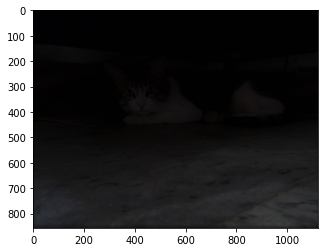

./my-test-images/pedestrians-walking-across-street-in-a-crosswalk-1030x686 - Copy.jpg


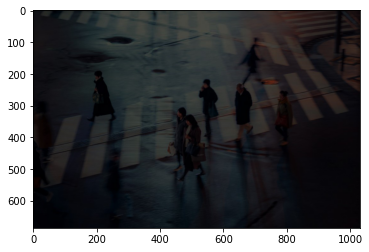

./my-test-images/cars-night.JPG


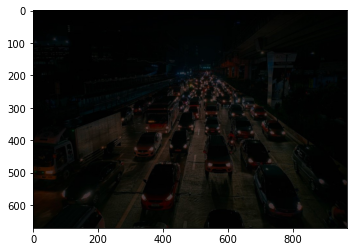

In [ ]:
display_images(args_test_dir)

# Test Images (after enhancement)

./my-test-images-result/pedestrians-walking-across-street-in-a-crosswalk-1030x686 - Copy_S.jpg


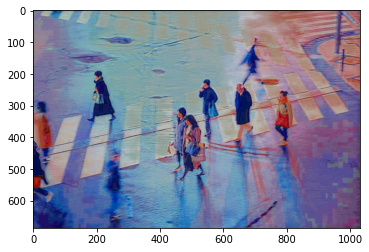

./my-test-images-result/IMG_20200619_124956_S.jpg


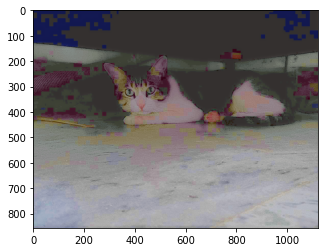

./my-test-images-result/cars-night_S.JPG


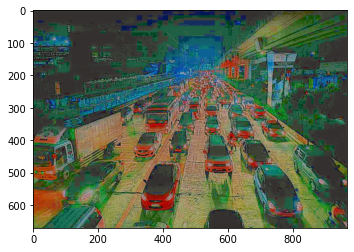

In [ ]:
display_images(args_save_dir)